# Telefonos

#BENJAMIN OSVALDO ALVIRDE MELENDEZ

## Preparación de ambiente

### Carga de módulos

In [1]:
# Data Wrangling
import os
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Modeling
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

# Data Visualization
import cufflinks as cf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Configuración del notebook
cf.go_offline()

### Preparación de carpetas

In [2]:
if not os.path.exists("./models/"):
    os.mkdir("./models/")

### Validación de hardware

In [3]:
print('Tensorflow version:', tf.__version__)
print('Is using GPU?', tf.config.list_physical_devices("GPU"))

Tensorflow version: 2.5.0
Is using GPU? []


## Data Wrnagling

### Establecimiento de rutas

In [4]:
main_dir = "/home/balvirde/diplomado"

In [5]:
train_dir = os.path.join(main_dir, 'train')

In [6]:
test_dir = os.path.join(main_dir, 'test')

#### Carpetas de entrenamiento

In [7]:
train_Serviciable_dir = os.path.join(train_dir, 'No_Serviciable')
train_No_Serviciable_dir = os.path.join(train_dir, 'Serviciable')

#### Carpetas de validación

In [8]:
test_Serviciable_dir = os.path.join(test_dir, 'No_Serviciable')
test_No_Serviciable_dir = os.path.join(test_dir, 'Serviciable')

In [9]:
### Tamaño de los conjuntos de datos

In [10]:
train_Serviciable_names = os.listdir(train_Serviciable_dir)

In [11]:
len(train_Serviciable_names)

27

In [12]:
train_No_Serviciable_names = os.listdir(train_No_Serviciable_dir)

In [13]:
len(train_No_Serviciable_names)

29

In [14]:
len(train_Serviciable_names)+len(train_No_Serviciable_names), len(train_Serviciable_names) / (len(train_Serviciable_names)+len(train_No_Serviciable_names))

(56, 0.48214285714285715)

In [15]:
test_Serviciable_names = os.listdir(test_Serviciable_dir)

In [16]:
len(test_Serviciable_names)

14

In [17]:
test_No_Serviciable_names = os.listdir(test_No_Serviciable_dir)

In [18]:
len(test_No_Serviciable_names)

11

### Data visualization

In [19]:
No_Serviciable_pic = [os.path.join(train_Serviciable_dir, filename) for filename in train_Serviciable_names[:8]]
Serviciable_pic = [os.path.join(train_No_Serviciable_dir , filename) for filename in train_No_Serviciable_names[:8]]

In [20]:
full_pic = Serviciable_pic+No_Serviciable_pic 

<Figure size 1728x1728 with 0 Axes>

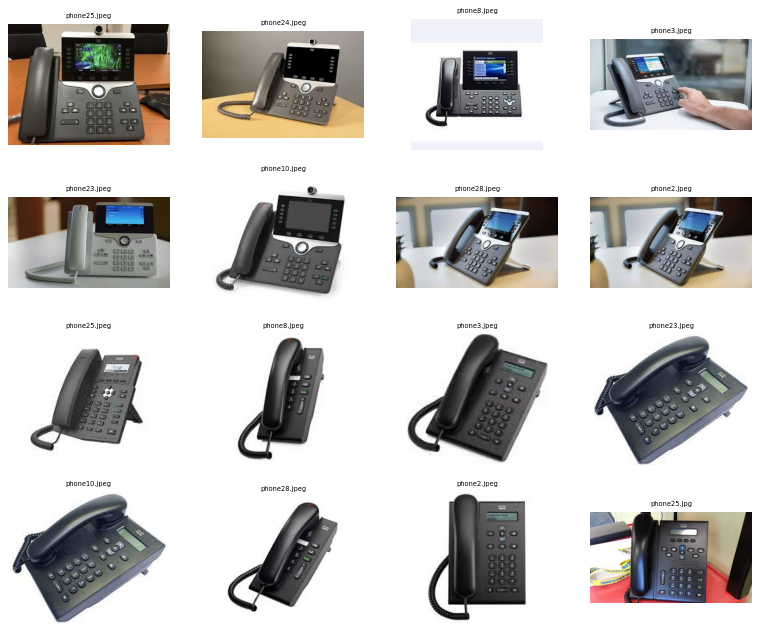

In [21]:
ROWS = 4
COLS = 4
fig = plt.gcf()
fig.set_size_inches(24, 24)
plt.figure(figsize=(12, 10), dpi=80)
for i, img_path in enumerate(full_pic):
    data = img_path.split('/')[-1]
    sp = plt.subplot(ROWS, COLS, i+1)
    sp.axis('Off')
    img = mpimg.imread(img_path)
    sp.set_title(data, fontsize=6)
    plt.imshow(img, cmap='gray')
plt.show()

### Generadores

In [22]:
dgen_train = ImageDataGenerator(rescale=1./255,
                                validation_split=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True)

In [23]:
dgen_validation = ImageDataGenerator(rescale=1./255)

In [24]:
dgen_test = ImageDataGenerator(rescale=1./255)

In [25]:
TARGET_SIZE = (200, 200)
BATCH_SIZE = 32
CLASS_MODE = 'binary'

In [26]:
train_generator = dgen_train.flow_from_directory(train_dir,
                                                 target_size=TARGET_SIZE,
                                                 subset='training',
                                                 batch_size=BATCH_SIZE,
                                                 class_mode=CLASS_MODE)

Found 46 images belonging to 2 classes.


In [27]:
validation_generator = dgen_train.flow_from_directory(train_dir,
                                                      target_size=TARGET_SIZE,
                                                      subset='validation',
                                                      batch_size=BATCH_SIZE,
                                                      class_mode=CLASS_MODE)

Found 10 images belonging to 2 classes.


In [28]:
test_generator = dgen_test.flow_from_directory(test_dir,
                                               target_size=TARGET_SIZE,
                                               batch_size=BATCH_SIZE,
                                               class_mode=CLASS_MODE)

Found 25 images belonging to 2 classes.


#### Target

In [29]:
train_generator.class_indices

{'No_Serviciable': 0, 'Serviciable': 1}

#### Tamaño de los vectores de entrada

In [30]:
train_generator.image_shape

(200, 200, 3)

## Modelado

### Establecimiento de base

In [31]:
model = Sequential()

### Capas Convolucionales+Pooling

In [32]:
model.add(Conv2D(64, (5,5), padding='same', activation='relu',
                input_shape=(200, 200, 3)))
model.add(MaxPooling2D(pool_size=(2,2)))

### Dropout

In [33]:
model.add(Dropout(0.2))

### Bloque convolucional

In [34]:
model.add(Conv2D(64, (5,5), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

### Capas densamente conectadas

In [35]:
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 200, 200, 64)      4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 100, 100, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 64)      102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 160000)            0

### Parámetros de entrenamiento

In [36]:
model.compile( loss='binary_crossentropy', metrics=['accuracy'])

### Callbacks

#### Early stopping

In [37]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                           patience=20)

#### Checkpoints

In [38]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('models/model_{val_accuracy:.3f}.h5',
                               save_best_only=True,
                               save_weights_only=False,
                               monitor='val_accuracy'
                                 )

### Entrenamiento del modelo

In [39]:
history = model.fit(train_generator,
          epochs=27,
          validation_data=validation_generator,
          callbacks=[early_stopping, checkpoint])

Epoch 1/27
2/2 [==============================] - 17s 4s/step - loss: 123.0131 - accuracy: 0.3561 - val_loss: 1.7528 - val_accuracy: 0.5000
Epoch 2/27
2/2 [==============================] - 4s 2s/step - loss: 3.5328 - accuracy: 0.5539 - val_loss: 0.7043 - val_accuracy: 0.5000
Epoch 3/27
2/2 [==============================] - 4s 2s/step - loss: 0.7631 - accuracy: 0.4751 - val_loss: 0.6952 - val_accuracy: 0.5000
Epoch 4/27
2/2 [==============================] - 4s 2s/step - loss: 0.7004 - accuracy: 0.5063 - val_loss: 0.6842 - val_accuracy: 0.5000
Epoch 5/27
2/2 [==============================] - 4s 2s/step - loss: 1.1571 - accuracy: 0.5104 - val_loss: 0.7266 - val_accuracy: 0.5000
Epoch 6/27
2/2 [==============================] - 4s 2s/step - loss: 0.9348 - accuracy: 0.4647 - val_loss: 0.6883 - val_accuracy: 0.5000
Epoch 7/27
2/2 [==============================] - 4s 3s/step - loss: 0.6825 - accuracy: 0.5238 - val_loss: 0.6859 - val_accuracy: 0.7000
Epoch 8/27
2/2 [======================

## Evaluación de resultados

### Resultados de entrenamiento

In [40]:
results = pd.DataFrame(data = zip(history.history["loss"], history.history["val_loss"], history.history["accuracy"], history.history["val_accuracy"]), columns=["loss", "val_loss", "accuracy", "val_accuracy"])

In [41]:
results.iplot()

### Calificación de validate

In [42]:
[x.split(".")[-2] for x in os.listdir("./models/")]

['713',
 '729',
 '650',
 '000',
 '555',
 '724',
 '619',
 '708',
 '674',
 '900',
 '711',
 '500',
 '800',
 '731',
 '665',
 '663',
 '721',
 '712',
 '700',
 '722',
 '690',
 '716',
 '600',
 '944',
 '676',
 '693']

In [43]:
max_acc = max([x.split(".")[-2] for x in os.listdir("./models/")])

In [44]:
max_acc

'944'

In [45]:
#model = tf.keras.models.load_model(f'./models/model_0.{max_acc}.h5')

In [46]:
test_loss, test_acc = model.evaluate(test_generator)
print('Test loss: {} Test Acc: {}'.format(test_loss, test_acc))

1/1 [==============================] - 0s 410ms/step - loss: 0.1173 - accuracy: 0.9200
Test loss: 0.1172674372792244 Test Acc: 0.9200000166893005


### Prediciendo con una nueva imágen

In [58]:
test_image = load_img('/home/balvirde/Documentos/Prueba/phone91.jpg',
                            target_size=(200,200))

In [59]:
images = img_to_array(test_image)

In [60]:
images.shape

(200, 200, 3)

In [61]:
images = np.expand_dims(images, axis=0)

In [62]:
images.shape

(1, 200, 200, 3)

In [63]:
prediction = model.predict(images)

In [64]:
if prediction == 0:
    print('No serviciable')
else:
    print('Serviciable')

No serviciable


In [65]:
model.save("cnn_phone.h5")